In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../../../neuroprob")


import neuroprob as mdl
from neuroprob import utils

import utils_func

dev = utils.pytorch.get_device()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.7.1+cu101
Using device: cuda:0


In [234]:
import importlib
import neuroprob

In [235]:
#importlib.reload(neuroprob.neural_utils)
from neuroprob import utils.neural as neural_utils

In [2]:
import os
os.getcwd()

'C:\\Users\\Mattijs\\Documents\\Mattijs\\Engineering IIB\\Thesis\\neural-data-analysis\\notebook\\CA_precession'

In [4]:
os.chdir('..')
os.getcwd()

'C:\\Users\\Mattijs\\Documents\\Mattijs\\Engineering IIB\\Thesis\\neural-data-analysis'

### Loading data

In [4]:
# loading data
dataset = 'hc3'
session_id = 'ec014.468'

data = np.load('./saves/{}_{}.npz'.format(dataset, session_id))
spktrain = data['spktrain']
x_t = data['x_t']
y_t = data['y_t']
hd_t = data['hd_t']
theta_t = data['theta_t']
eeg_t = data['eeg_t']
sample_bin = data['sample_bin']


vx_t = (x_t[1:]-x_t[:-1])/sample_bin
vy_t = (y_t[1:]-y_t[:-1])/sample_bin
vx_t = np.concatenate((vx_t, vx_t[-1:]))
vy_t = np.concatenate((vy_t, vy_t[-1:]))
s_t = np.sqrt(vx_t**2 + vy_t**2)

left_x = x_t.min()
right_x = x_t.max()
bottom_y = y_t.min()
top_y = y_t.max()

arena_width = right_x - left_x
arena_height = top_y - bottom_y



track_samples = len(x_t)
units = spktrain.shape[0]

In [6]:
sep_t_spike = []
for k in range(units):
    sep_t_spike.append(neural_utils.BinToTrain(spktrain[k]))
    
ISI, LV = neural_utils.compute_ISI_LV(sample_bin, sep_t_spike) # compute ISIs and bursting coefficient

### Selecting runs

In [233]:
# Gaussian
filter_size = 10001
t = np.arange(filter_size)
t_cent = (filter_size // 2)
l = 10000 # 8000 ms gaussian std
smth_filter = np.exp(-0.5*((t-t_cent)/l)**2)
smth_filter[t_cent+1:] = 0 # causal filter
smth_filter = smth_filter / smth_filter.sum() # normalize


# smth_vx_t = neuroprob.neural_utils.smooth_hist(vx_t[None, :], smth_filter, ['repeat'], dev)
# smth_vx_t = smth_vx_t[0]

smth_vx_t = np.convolve(vx_t, smth_filter, 'same')

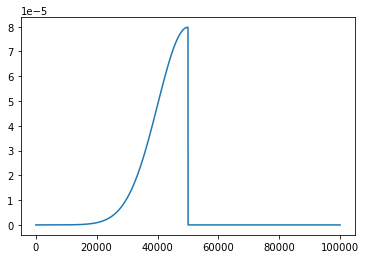

In [11]:
plt.plot(smth_filter)

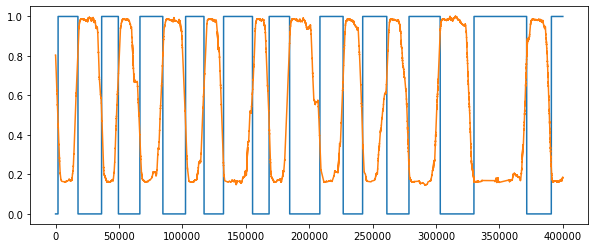

In [10]:
plt.figure(figsize=(10,4))
plt.plot(smth_vx_t[1000000:1400000]>0)
plt.plot(x_t[1000000:1400000]/300)

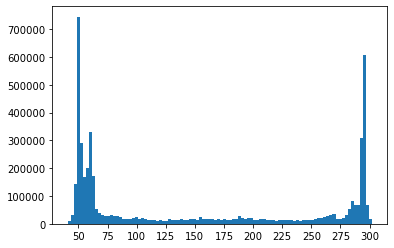

In [11]:
n, bins, _ = plt.hist(x_t, bins=100)
plt.xticks(np.arange(50,301,25))
plt.show()

In [191]:
ndir_t = utils_func.new_L_R_run(x_t)
np.shape(ndir_t)

(4877928,)

In [192]:
print(np.sum((ndir_t == 0) & (dir_t == -1)))
print(np.sum(ndir_t==0))

0
671120


In [143]:
c_x_t = utils_func.class_x_t(x_t)
dir_t = utils_func.L_R_run(c_x_t)
ind_L_R = np.where(dir_t == -1)
ind_R_L = np.where(dir_t == 1)
ind_stat = np.where(dir_t == 0)

# incompleted runs:  1


Comparing various run splitting functions:

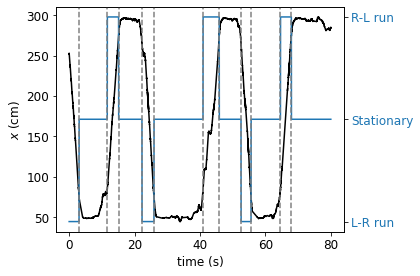

In [255]:
start = 1100000
dur = 100000

fig, ax1 = plt.subplots()

color = 'black'
ax1.set_xlabel('time (s)')
ax1.set_ylabel(r'$x$ (cm)', color=color)
ax1.plot(np.linspace(0, dur*sample_bin, dur), x_t[start:start+dur], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel(r'Velocity', color=color)  # we already handled the x-label with ax1
ax2.plot(np.linspace(0, dur*sample_bin, dur), dir_t[start:start+dur], color=color)
[ax2.axvline(point*sample_bin, ls='--', color='grey') for point in np.squeeze(np.where(np.diff(dir_t[start:start+dur]) != 0))]
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(ticks = [-1, 0, 1])
ax2.set_yticklabels(labels=['L-R run', 'Stationary', 'R-L run'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [308]:
n_spikes_L_R = np.sum(spktrain[:, ind_L_R], axis=(1, 2), dtype=int)
n_spikes_R_L = np.sum(spktrain[:, ind_R_L], axis=(1, 2), dtype=int)
n_spikes_stat = np.sum(spktrain[:, ind_stat], axis=(1, 2), dtype=int)
n_spikes = np.vstack((n_spikes_L_R, n_spikes_stat, n_spikes_R_L))

### Compute histograms for tuning

In [163]:
# binning of covariates and analysis
bins_x = 40
bins_y = int(arena_height/arena_width*bins_x)
bins_theta = 20
bins_vx = 2
bins_dir = 3

bin_x = np.linspace(left_x, right_x+1e-3, bins_x+1)
bin_y = np.linspace(bottom_y, top_y+1e-3, bins_y+1)
bin_theta = np.linspace(0, 2*np.pi+1e-3, bins_theta+1)
bin_vx = np.array([smth_vx_t.min(), 0, smth_vx_t.max()+1e-3])
bin_dir = np.array([-1, -0.5, 0.5, 1+1e-3])

corr_t_spikes = utils.neural.spike_threshold(sample_bin, 0.25, (x_t, y_t), (bin_x, bin_y), sep_t_spike)
sp_rate, sp_prob = utils.neural.IPP_model(sample_bin, 0.25, (x_t, y_t), (bin_x, bin_y), sep_t_spike, divide=True)
sp_MI = utils.neural.spike_var_MI(sp_rate, sp_prob)


sm_size = 5
sm_filter = np.ones((sm_size, sm_size)) / sm_size**2
smth_rate = utils.neural.smooth_hist(sp_rate, sm_filter, ['repeat', 'repeat'], dev='cpu')
coherence, sparsity = utils.neural.geometric_tuning(sp_rate, smth_rate, sp_prob) # coherence and sparsity of fields

In [171]:
unit_discard = np.intersect1d(np.where(n_spikes_L_R < 200), np.where(n_spikes_R_L < 200))
print("# discarded units (< 200 spikes): ", len(unit_discard))
unit_used = np.union1d(np.where(n_spikes_L_R > 200), np.where(n_spikes_R_L > 200))
print("Units left: ", len(unit_used))

# discarded units (< 200 spikes):  39
[ 2  6  7 13 15 16 17 18 19 22 23 27 29 30 32 40 45 46 47 48 49 50 52 54
 58 60 61 62 65 67 72 73 74 75 78 80 81 82 90]
Units left:  57


In [172]:
# Discard neurons if not sparse, enough (inhibitory neurons always ON)
unit_used = np.intersect1d(unit_used, np.argsort(sparsity)[18:])
print("Units left: ", len(unit_used))

Units left:  39


In [95]:
l_x = arena_width / bins_x


bins_y = int(arena_height/arena_width*bins_x)
bin_x = np.linspace(left_x, right_x+1e-3, bins_x+1)
bin_y = np.linspace(bottom_y, top_y+1e-3, bins_y+1)
bins_tuple = (bin_x, bin_y)
behav_list = [x_t, y_t]

model = mdl.nonparametrics.histogram(bins_tuple, neurons=1)

rate, prob = utils.neural.IPP_model(sample_bin, 0.125, behav_list, model.bins_cov, sep_t_spike)
model.set_params(sample_bin, w=rate)
#model.to(dev)

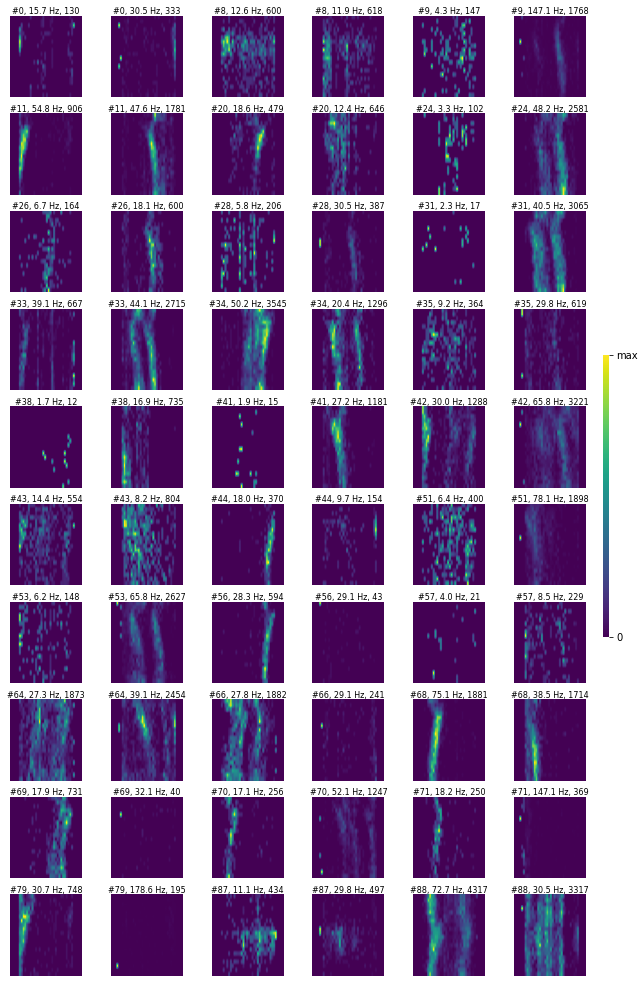

In [174]:
W = 6
H = int(np.ceil(len(unit_used) / 3))
# H = 54
widths = np.ones(W)
heights = np.ones(H)

fig = plt.figure(figsize=(8, 8/6*H))
spec = fig.add_gridspec(ncols=W, nrows=H, width_ratios=widths,
                        height_ratios=heights, wspace=0.4, 
                        left=0., right=1., bottom=0.0, top=1.)

for nr in range(H):
    for nc in range(W):
        nnn = (nr*W + nc)
        try:
            run_type = (nnn % 2)*2
            n_neuron = unit_used[nnn // 2]
            rate_profile = xtheta_rate[n_neuron][run_type, ...]
#             rate_profile = xtheta_rate[unit_used[nnn]][1, ...] # stat. runs
            ax = fig.add_subplot(spec[nr, nc])
            ax.set_title('#{}, {:.1f} Hz, {}'.format(n_neuron, rate_profile.max(), n_spikes[run_type, n_neuron]), fontsize=8, pad=-10)
            _, ax, im = tools.draw_2d(np.transpose(rate_profile), origin='lower', aspect='auto', 
                                      cmap='viridis', vmax=rate_profile.max(), figax=(fig, ax))
            tools.decorate_ax(ax, spines=[False, False, False, False])
        except IndexError:
            continue
        
# colorbar
W = 1
H = 3
widths = np.ones(W)
heights = np.ones(H)
spec = fig.add_gridspec(ncols=W, nrows=H, width_ratios=widths,
                        height_ratios=heights, 
                        left=1.03, right=1.04, bottom=0., top=1.)
ax = fig.add_subplot(spec[1, 0])
tools.add_colorbar(im, fig, ax, ticktitle='', ticks=[0, rate_profile.max()], ticklabels=['0', 'max'], 
                   cbar_format=None)

plt.show()

### Theta analysis

In [143]:
# EEG fourier transform
eeg_t_avg = eeg_t.mean(0)

time_steps = eeg_t_avg.shape[0]
timePeriod = sample_bin*time_steps


# FFT of the average EEG signal
fourierTransform = np.fft.rfft(eeg_t_avg)
fourierTransform = fourierTransform[:time_steps//2] # Nyquist upper bound

freq = np.arange(time_steps//2)/timePeriod # in Hz

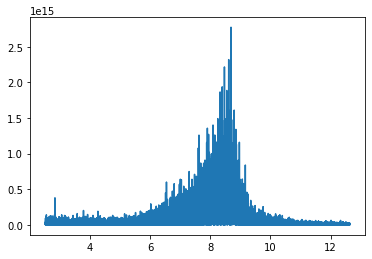

In [144]:
plt.plot(freq[10000:50000], np.abs(fourierTransform[10000:50000])**2)

In [309]:
# Cross-correlograms of spiking activity in population
tbin, resamples, rc_t, behav_t = neural_utils.BinTrain(5, sample_bin, spktrain, track_samples, 
                                           (x_t, y_t, theta_t), average_behav=False, binned=True)

u = 12
cross_correlate = False
correlation = False

cg = neural_utils.spike_correlogram(rc_t[:u, :], 1, 500, 700000, start_step=10000, ref_point=250, cross=cross_correlate, 
                                    correlation=correlation, dev='cpu')

s = 0
if cross_correlate:
    cg_ = np.zeros((u, u, cg.shape[-1]))
    for u_ in range(u):
        cg_[u_:, u_] = cg[s:s+u-u_]
        s += u-u_

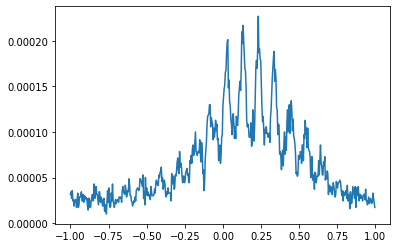

In [187]:
plt.plot(np.arange(-250, 250)*tbin, cg_[11, 9, :])

In [162]:
s = cg
time_steps = s.shape[1]
timePeriod = tbin*time_steps

# FFT of the cg
fourierTransform = np.fft.rfft(s)
fourierTransform = fourierTransform[:time_steps//2] # Nyquist upper bound

FP = np.abs(fourierTransform)**2

freq = np.arange(time_steps//2+1e-3)/timePeriod # in Hz


"""
References:

`Theta-modulated place-by-direction cells in the hippocampal formation in the rat`,
Cacucci, F; Lever, C; Wills, TJ; Burgess, N; O'Keefe, J (2004)

"""
freq_low_limit = 5.
freq_bin = 1./timePeriod

theta_index = np.empty((units))
theta_period = np.empty((units))

border = int(freq_low_limit/freq_bin) # bigger than 5 Hz

theta_period = (np.argmax(FP[:, border:], axis=1) + border)*freq_bin
theta_index = FP[:, border:].max(axis=1)/FP[:, border:].min(axis=1)

0.5
[  5.791718     1.40465058   4.23311271  43.94863411  57.8050747
 143.22540447   1.           1.59413645   3.73976445  11.2560085
   3.47618609  20.03515501]


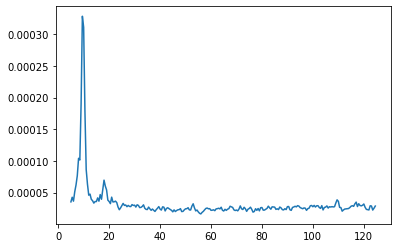

In [156]:
plt.plot(freq[border:250], FP[11, border:250])
print(1/timePeriod)

# significant theta modulation
print(theta_index)

In [253]:
"""
phase precession metric

Instead of time, spikes are now ordered along the theta axis (unwrapped), which warps their 
distances to the theta oscillations time flow. If there is precession, the spikes should be 
most correlated slightly before autocorrelation at 2 pi difference.
"""

u_theta_t = np.unwrap(theta_t) - theta_t[0]
u_theta_s, = neural_utils.CovariatesAtSpikes(sep_t_spike, (u_theta_t,))
theta_periods = int(u_theta_t.max() / (2*np.pi))+1

bins_per_period = 60
bin_theta = np.linspace(0, theta_periods*2*np.pi, theta_periods*bins_per_period+1)

# phase precession
lag_range = 100
theta_window = len(bin_theta)-1

spikes_theta = np.zeros((units, theta_window))
for u in range(units):
    theta_ind = np.digitize(u_theta_s[u], bin_theta)-1
    np.add.at(spikes_theta[u, :], theta_ind, 1)

u = 12
cg = neural_utils.spike_correlogram(spikes_theta[:u, :], 1, lag_range, 1800000, start_step=0, ref_point=0, cross=False, 
                                    correlation=False, dev='cpu')

torch.Size([12, 1, 1800000]) torch.Size([12, 100, 1800000])


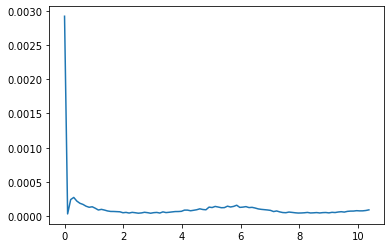

In [254]:
plt.plot(bin_theta[:100], cg[11, :100])

In [255]:
freq_low_limit = 5.
border = int(freq_low_limit/freq_bin) # bigger than 5 Hz

# FFT to get estimate of theta period
fourierTransform = np.fft.rfft2(cg, axes=(1,))
fourierTransform = fourierTransform[:, :int(lag_range/2)] # Nyquist
FP = np.abs(fourierTransform)**2

freq_bin = 1/bins_per_period
freq = np.arange(lag_range//2)*freq_bin

border = bins_per_period//2
relative_precess_freq = (np.argmax(FP[:, border:], axis=1)+border)*freq_bin
precess_index = relative_precess_freq - 1.
precess_amount = np.max(FP[:, border:], axis=1)/np.min(FP[:, border:], axis=1)

In [ ]:
print(precess_index)
print(precess_amount)

In [115]:
# fit gamma distribution with oscillatory modulation to ISI distribution
ISI_ = []
for u in range(units):
    if len(ISI[u]) > 10:
        ISI_.append(ISI[u])
    
x, y, hist_amp, params = utils.fit_oscillatory_ISI(sample_bin*10, ISI_, 2000, max_iters=2000, lr=1e-2, dev=dev)
omega_p = params[0]

corr_eeg, fit_eeg, params = \
    utils.EEG_fit(sample_bin, eeg_t.mean(0), lag_range=1250, time_window=100000, lr=1e-3, dev=dev)

omega_eeg, tau_eeg, power_decay = params

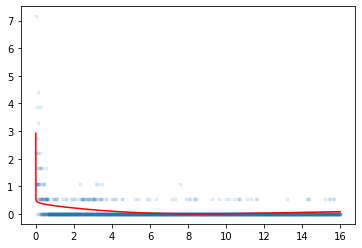

In [120]:
unit = 11

plt.plot(x, y[unit], c='r')
plt.scatter(x, hist_amp[unit], marker='.', alpha=0.1)
plt.show()

0.12032306116173645


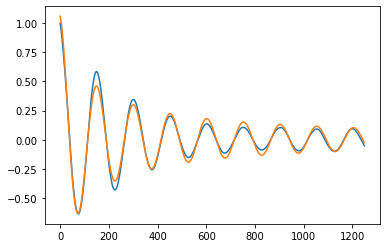

In [94]:
print(2*np.pi/omega_eeg) # theta period estimate from EEG

plt.plot(corr_eeg)
plt.plot(fit_eeg)
plt.show()